

✅ Using device: cpu

✅ Training on stock data from 2010 to 2024


Device set to use cpu





✅ Training LSTM model on stock data...
Epoch 1/150

44/44 [==============================] - 1s 2ms/step - loss: 24268.5703
Epoch 2/150
44/44 [==============================] - 0s 1ms/step - loss: 10419.9531
Epoch 3/150
44/44 [==============================] - 0s 2ms/step - loss: 1672.8181
Epoch 4/150
44/44 [==============================] - 0s 2ms/step - loss: 1035.3622
Epoch 5/150
44/44 [==============================] - 0s 2ms/step - loss: 909.4815
Epoch 6/150
44/44 [==============================] - 0s 2ms/step - loss: 843.9380
Epoch 7/150
44/44 [==============================] - 0s 2ms/step - loss: 819.4182
Epoch 8/150
44/44 [==============================] - 0s 2ms/step - loss: 801.0980
Epoch 9/150
44/44 [==============================] - 0s 1ms/step - loss: 816.3879
Epoch 10/150
44/44 [==============================] - 0s 1ms/step - loss: 794.5519
Epoch 11/150
44/44 [==============================] - 0s 1ms/step - loss: 787.3669
Epoch 12/150
44/44 [===========================

C:\Users\Rishi\anaconda3\envs\stonks\lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


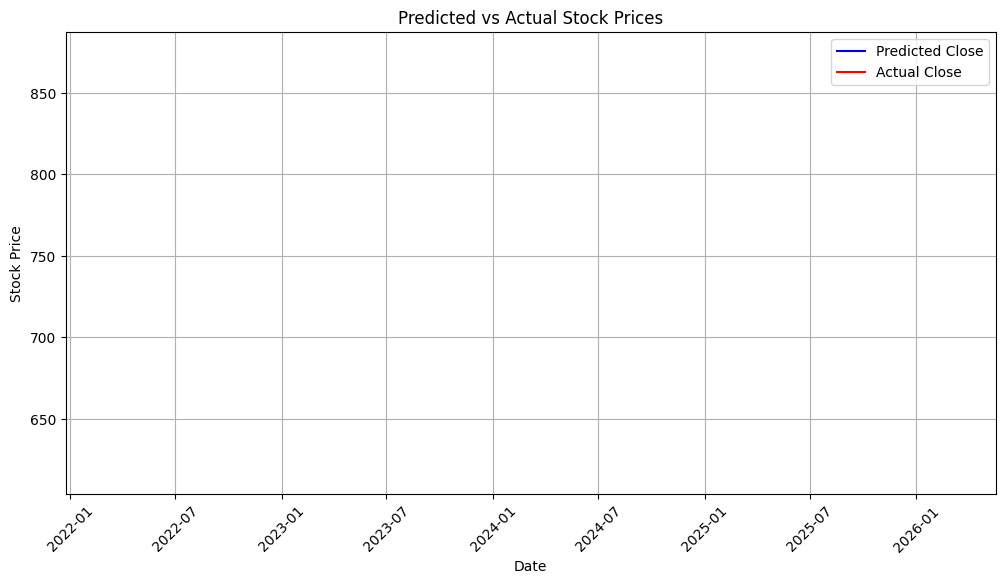

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Check Device Availability (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# ✅ Load Stock & News Data
stock_file = "stock_data.csv"
news_file = "news_data.csv"
new_news_file = "new_news_data.csv"
actual_file = "actual.csv"

if not all(os.path.exists(f) for f in [stock_file, news_file, new_news_file, actual_file]):
    raise FileNotFoundError("\n❌ Error: Required data file not found!")

stock_data = pd.read_csv(stock_file)
news_data = pd.read_csv(news_file)
new_news_data = pd.read_csv(new_news_file)
actual_data = pd.read_csv(actual_file)

# ✅ Convert Date Format
for df in [stock_data, news_data, new_news_data, actual_data]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# ✅ Train on Stock Data (2010–2024)
stock_data = stock_data[stock_data["date"] >= "2010-01-01"]
print("\n✅ Training on stock data from 2010 to 2024")

# ✅ Add Technical Indicators
stock_data["daily_change"] = stock_data["close"] - stock_data["open"]
stock_data["volatility"] = stock_data["high"] - stock_data["low"]
stock_data["50_day_MA"] = stock_data["close"].rolling(window=50).mean()
stock_data["200_day_MA"] = stock_data["close"].rolling(window=200).mean()
stock_data.fillna(0, inplace=True)  # Fill NaNs with 0

# ✅ Load Sentiment Analysis Model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=-1)

# ✅ Apply Sentiment Analysis
def get_sentiment(text):
    try:
        result = sentiment_pipeline(text)[0]["label"]
        return 1 if result == "POSITIVE" else (-1 if result == "NEGATIVE" else 0)
    except Exception:
        return 0  # Handle errors gracefully

news_data["sentiment"] = news_data["news_summary"].apply(get_sentiment)
news_data = news_data.groupby("date").agg({"sentiment": "mean"}).reset_index()

# ✅ Merge Stock Data with Sentiment Data
merged_data = pd.merge(stock_data, news_data, on="date", how="left").fillna(0)

# ✅ Prepare Features and Targets
features = ["sentiment", "volume", "daily_change", "volatility", "50_day_MA", "200_day_MA"]
X_train = merged_data[features]
y_train = merged_data["close"]

# ✅ Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# ✅ Build LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(256, input_shape=(1, len(features)), return_sequences=False),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

# ✅ Train LSTM Model on Stock Data
model_stock = build_lstm_model()
print("\n✅ Training LSTM model on stock data...")
model_stock.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

# ✅ Predict Sentiment for New News Data
new_news_data["sentiment"] = new_news_data["news_summary"].apply(get_sentiment)
new_news_data = new_news_data.groupby("date").agg({"sentiment": "mean"}).reset_index()

# ✅ Merge New Sentiment Data with Last Known Stock Features
latest_stock_data = stock_data.iloc[-1]
for col in ["volume", "daily_change", "volatility", "50_day_MA", "200_day_MA"]:
    new_news_data[col] = latest_stock_data[col]

# ✅ Scale and Reshape Data for Prediction
if not new_news_data[features].isnull().values.any():
    X_test = scaler.transform(new_news_data[features])
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # ✅ Predict Stock Prices
    predicted_stock_prices = model_stock.predict(X_test)
    new_news_data["predicted_close"] = predicted_stock_prices

    # ✅ Save Predictions
    new_news_data.to_csv("predicted_stock_prices.csv", index=False)
    print("\n✅ Stock Price Predictions Saved Successfully!")
    print(new_news_data[["date", "sentiment", "predicted_close"]].head())

    # ✅ Merge Actual Close Prices for Comparison
    if "close" in actual_data.columns:
        actual_data.rename(columns={"close": "actual_close"}, inplace=True)
        predictions_with_actual = pd.merge(new_news_data, actual_data, on="date", how="left")

        # ✅ Drop NaN values before calculating metrics
        valid_data = predictions_with_actual.dropna(subset=["actual_close", "predicted_close"])
        if not valid_data.empty:
            mse = mean_squared_error(valid_data["actual_close"], valid_data["predicted_close"])
            mae = mean_absolute_error(valid_data["actual_close"], valid_data["predicted_close"])
            r2 = r2_score(valid_data["actual_close"], valid_data["predicted_close"])
            print(f"\n✅ Model Evaluation Metrics:")
            print(f"MSE: {mse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"R² Score: {r2:.4f}")
        else:
            print("\n❌ Not enough data to calculate evaluation metrics.")

        # ✅ Plot Predicted vs Actual Prices
        if not valid_data.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(valid_data["date"], valid_data["predicted_close"], label="Predicted Close", color="blue")
            plt.plot(valid_data["date"], valid_data["actual_close"], label="Actual Close", color="red")
            plt.xlabel("Date")
            plt.ylabel("Stock Price")
            plt.title("Predicted vs Actual Stock Prices")
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("\n❌ No data available to plot.")
    else:
        print("\n❌ Warning: 'close' column not found in actual.csv. Skipping actual price comparison.")
else:
    print("\n❌ Warning: NaN values detected in test data. Prediction skipped.")
